In [13]:
from hlgpr.hlgpr import LatentGPRegression
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm

## Set up "task"

In [8]:
n_subs = 5
n_tp = 30
n_trials = 30

test_data = {'Subject': np.arange(n_subs).repeat(n_tp * n_trials),
             'trial_number': np.tile(np.arange(n_trials).repeat(n_tp), n_subs),
             'time': np.tile(np.arange(n_tp), n_trials * n_subs),
             'pred1': np.tile(np.random.randn(30).repeat(n_tp), n_subs),
             'pred2': np.tile(np.random.randn(30).repeat(n_tp), n_subs)
             }
test_data = pd.DataFrame(test_data)

## Simulate data

The data is expected to be in Pandas dataframe that follows a standard format. The X variable is labelled `'time'`, and the subject variable is labelled `'Subject'`

In [9]:
time = test_data.groupby(['Subject', 'time']).mean().reset_index()[['time', 'Subject']].values

# X data = (n preds, n sub * n timepoints, n trials)
scale_x = False
preds = ['intercept', 'pred1', 'pred2', 'pred1:pred2']

for pred in preds:
    if ':' in pred:
        test_data[pred] = test_data[pred.split(':')].product(axis=1)

x_data = []
for pred in preds:
    if pred == 'intercept':
        x_data.append(np.ones((n_subs * n_tp, n_trials)))
    else:
        pred_data = test_data.set_index(['Subject', 'time']).pivot(columns='trial_number').reset_index()[pred].values
        if scale_x:
            pred_data = scale(pred_data, axis=1)
        x_data.append(pred_data)
x_data = np.stack(x_data)

n_tp = len(np.unique(time[:, 0]))
n_subs = len(np.unique(time[:, 1]))
n_preds = len(preds)

# PARAMETERS
# Covariance variance parameters - these control the influence of group vs subject level effects
η_group_true = [1, 0.8, 2, 3]
η_subject_true = [0.6, 0.2, 0.5, 0.8]

# Length scale parameters
ℓ_group_true = [3, 5, 2, 4]  # GROUP
ℓ_subject_true = [1, 2, 4, 1]  # SUBJECT

# Error
σ_true = 5

# GP FUNCTIONS
constants = [1.5, 2, 0.3, 0.7]
y = np.zeros(x_data.shape[1:])

group_functions = []
subject_functions = []

for n, pred in enumerate(preds):
    # Here we add a constant, this is the same across subjects 
    mean_func = pm.gp.mean.Constant(constants[n])
    
    # Two covariance matrices
    # First = "group" effect - single length scale parameter
    cov_group = η_group_true[n]**2 * pm.gp.cov.ExpQuad(1, ℓ_group_true[n])

    # Second = "subject" effect - two length scale parameters, just for the sake of making things easy in PyMC3. 
    # Second parameter needs to be LOW as it controls how similar adjacent subjects are
    cov_subject = (η_subject_true[n])**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=[ℓ_subject_true[n], 0.0001])
    
    # Latent functions
    # Group mean function
    f_group = np.random.multivariate_normal(mean_func(np.unique(time[:, 0])[np.newaxis, :].T).eval(),
                                           cov_group(np.unique(time[:, 0])[np.newaxis, :].T).eval() + 1e-8*np.eye(n_tp), 1).flatten()

    # Subject-level function
    f_subject = np.random.multivariate_normal(np.tile(f_group, n_subs),
                                           cov_subject(time).eval() + 1e-8*np.eye(time.shape[0]), 1).flatten()
    
    # Regression
    y += x_data[n, ...] * f_subject[:, np.newaxis]
    
    # Add functions to list (just for plotting etc)
    group_functions.append(f_group)
    subject_functions.append(f_subject)

# Add error to observations
y += σ_true * np.random.standard_normal(y.shape)

# Add Y to dataframe
test_data['y'] = y.reshape((n_subs, n_tp, n_trials)).transpose([0, 2, 1]).flatten()

In [16]:
test_data.head()

,Subject,trial_number,time,pred1,pred2,pred1:pred2,y
0,0,0,0,-0.853563,0.722661,-0.616837,-2.542907
1,0,0,1,-0.853563,0.722661,-0.616837,7.996411
2,0,0,2,-0.853563,0.722661,-0.616837,-0.933461
3,0,0,3,-0.853563,0.722661,-0.616837,4.758466
4,0,0,4,-0.853563,0.722661,-0.616837,4.291630


## Plot an individual subject

This should look like a mess - the raw data is determined by the combination of predictors and $\beta$ functions, which is what we will then need to decompose it into

Text(0.5, 1.0, 'Subject 1')

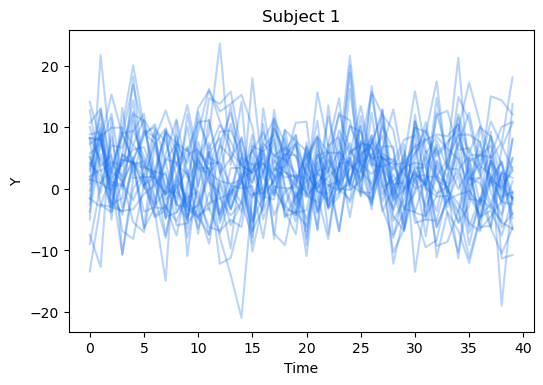

In [10]:
plt.figure(dpi=100)
plt.plot(y[:40, :], color='#1a73f0', alpha=0.3);
plt.xlabel('Time')
plt.ylabel('Y')
plt.title('Subject 1')

## Plot the underlying functions

These are the $\beta$ functions (timeseries) we will be attempting to recover

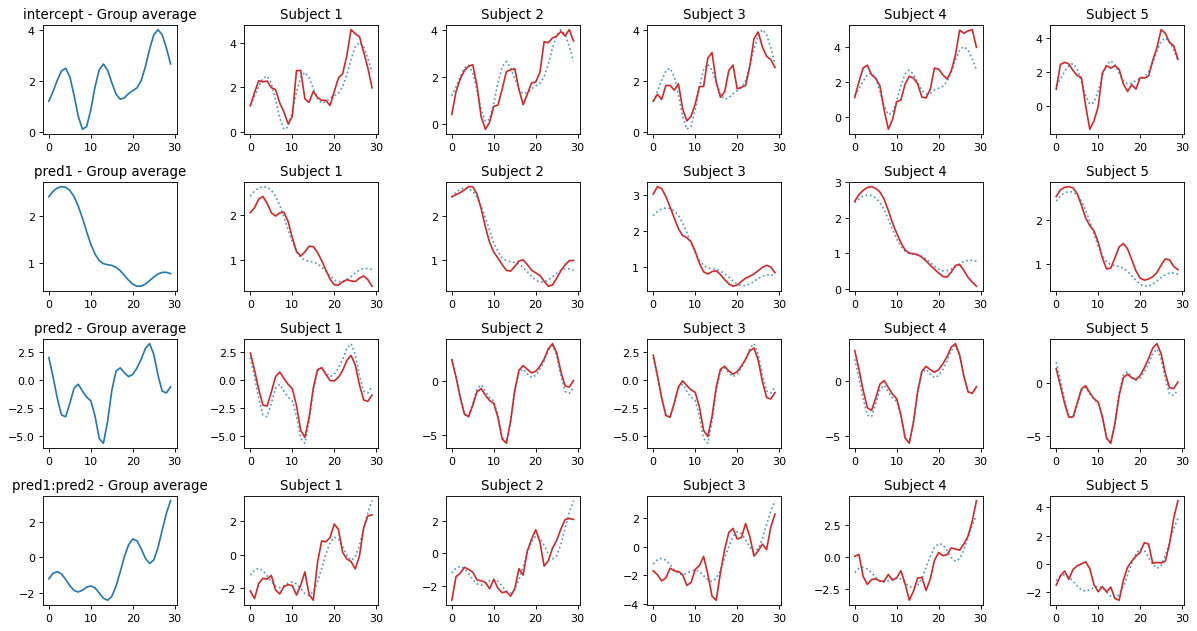

In [11]:
f, ax = plt.subplots(n_preds, n_subs + 1, figsize=((n_subs + 1) * 2.5, 2 * n_preds), dpi=80)

for i in range(n_preds):

    ax[i, 0].plot(group_functions[i])
    ax[i, 0].set_title('{0} - Group average'.format(preds[i]))


    for n in range(1, n_subs + 1):
        ax[i, n].plot(group_functions[i], linestyle=':', alpha=0.8)
        ax[i, n].plot(subject_functions[i][(n-1) * n_tp:n * n_tp], color='tab:red')
        ax[i, n].set_title('Subject {0}'.format(n))
    #     ax[n].scatter(range(n_tp), y[(n-1) * n_tp:n * n_tp, 19], s=2, color='gray')

plt.tight_layout()

## Specify the model

The model takes an ordinary regression equation as its model specification. **This only does fully random effects models, with each subject having their own intercept & slopes, right now**. So in effect, all the terms in the model have `|Subject` appended to them

In [14]:
lgpr = LatentGPRegression('y ~ 1 + pred1 + pred2 + pred1:pred2', test_data, 'time')

## Fit the model

By default, this uses variational inference. This can be changed to mcmc by setting `method='mcmc'`. Arguments for the underlying PyMC3 fitting functions can also be provided.

In [15]:
lgpr.fit(n=40000)

  0%|                                                                                                                         | 0/40000 [00:00<?, ?it/s]C:\Users\tobyw\Miniconda3\envs\mne\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 54,713: 100%|█████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [04:25<00:00, 150.60it/s]
Finished [100%]: Average Loss = 54,713


As we used variational inference, we need to sample from the approximated posterior to take a look at the results

In [18]:
trace = lgpr.approx.sample(2000)

## Plot the results

Here we plot a couple of the recovered group-level $\beta$ functions, compared with the true ones used to generate the data.

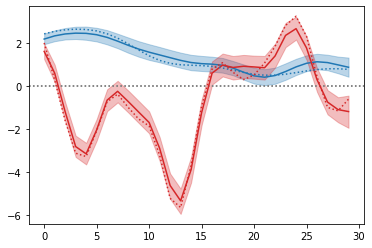

In [25]:
# plt.figure(figsize=(20, 10))

pal = ['tab:blue', 'tab:red']

for n, i in enumerate(['pred1', 'pred2']):
    var = 'Latent_GP__{0}___group'.format(i)
    m = trace[var].mean(axis=0)
    ci_upper = np.percentile(trace[var], 97.5, axis=0)
    ci_lower = np.percentile(trace[var], 2.5, axis=0)
    
    plt.fill_between(range(len(m)), ci_lower, ci_upper, alpha=0.3, color=pal[n])
    plt.axhline(0, linestyle=':', color='gray')
    plt.plot(m, color=pal[n], linewidth=1.5)
    
plt.plot(group_functions[1], color=pal[0], linestyle=':')
plt.plot(group_functions[2],color=pal[1], linestyle=':')